# mixed model

pickle the model files and load here to test

In [1]:
import numpy as np
import pandas as pd
import spacy
import networkx as nx
import score as sc
import time
from sklearn.metrics import confusion_matrix, pairwise, f1_score, precision_score
from scipy.spatial import distance
from preprocessing.utils import plot_confusion_matrix
import matplotlib.pyplot as plt
import nltk
from collections import Counter, defaultdict
import itertools
import importlib
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

/Users/dannyyang/Library/Python/3.6/lib/python/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [8]:
import en_coref_md
nlp = spacy.load('en_core_web_sm')
coref = en_coref_md.load()

In [29]:
# In[21]:


negating_words = set([
    "n't", "not", "no", 
    "never", "nobody", "non", "nope"])
doubting_words = set([
    'fake','fraud', 'hoax', 
    'false', 'deny', 'denies', 
    'despite', 'doubt', 
    'bogus', 'debunk', 'prank', 
    'retract', 'scam', "withdrawn",
    "misinformation"])
hedging_words = set([
    'allege', 'allegedly','apparently',
    'appear','claim','could',
    'evidently','largely','likely',
    'mainly','may', 'maybe', 'might',
    'mostly','perhaps','presumably',
    'probably','purport', 'purportedly',
    'reported', 'reportedly',
    'rumor', 'rumour', 'rumored', 'rumoured',
    'says','seem','somewhat',
    'unconfirmed'])
sus_words = doubting_words.union(hedging_words)


# In[92]:


from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
vader = SentimentIntensityAnalyzer()

def get_sentiment(sentence):
    sent =  vader.polarity_scores(sentence)
    return [sent["pos"],sent["neg"],sent["neu"],sent["compound"]]

def get_avg_sentiment(lst):
    sents = np.array([get_sentiment(s) for s in lst])
    return list(np.mean(sents, axis = 0))

def get_diff_sentiment(a,b):
    return list(np.array(a) - np.array(b))


# In[23]:


def train_test_split(bodies, stances, split=0.8):
    idx = np.random.permutation(np.arange(len(bodies)))
    bodies = bodies.values[idx]
    train = int(len(bodies)*0.8)
    bodies_tr = set([i[0] for i in bodies[:train]])
    bodies_val = set([i[0] for i in bodies[train:]])
    stances_tr = stances.loc[stances["Body ID"].isin(bodies_tr), :]
    stances_val = stances.loc[stances["Body ID"].isin(bodies_val), :]
    return stances_tr, stances_val

# In[26]:


def get_body(n):
    return test_bodies.loc[lambda x: x["Body ID"] == n, "articleBody"].item()


# In[27]:


def preprocess(text):
    text = text.replace("' ",' ')
    text = text.replace("'\n",'\n')
    text = text.replace(" '",' ')
    text = text.replace('"',' ')
    text = text.replace('“',' ')
    text = text.replace('”', ' ')
    text = text.replace(":", ". ")
    text = text.replace(";", ". ")
    text = text.replace("...", " ")
    return text


# In[28]:


def cosine_similarity(x,y):
    if all([a == 0 for a in x]) or all([a == 0 for a in y]):
        return 0
    return 1 - np.nan_to_num(distance.cosine(x,y))


# In[29]:


def get_topics(doc):
    """
    get topics of a sentence
    input: spacy doc
    output: dictionary with nouns as the key, and the set of noun chunks that contain the noun as the value
    special entry _vocab has the set of all tokens in the dict
    """
    subjs = {}
    for chunk in doc.noun_chunks:
        if len(chunk.root.text) > 2 and chunk.root.pos_ not in ["NUM", "SYM","PUNCT"]:
            txt = chunk.root.lemma_.lower()
            if txt not in subjs:
                subjs[txt] = set([txt])
            subjs[txt].add(chunk.text.lower())
    subjects_= []
    for word in subjs:
        for phrase in subjs[word]:
            subjects_ += phrase.split(" ")
    subjs["_vocab"] = set(subjects_)
    return subjs


# In[30]:


def get_svos(sent):
    """
    input: Spacy processed sentence
    output: dict of subj, dict of v, dict of obj (each word is lemmatized and lowercased)
    each entry in dict has key of lemmatized token, value is actual token (to do traversals with later if needed)
    """
    s = {}
    v = {}
    o = {}
    for token in sent:
        if token.dep_ == 'ROOT':
            v[token.lemma_.lower()] = token
        elif token.dep_ in ["nsubj", "nsubjpass", "csubj","csubjpass", "agent","compound"]:
            s[token.lemma_.lower()] = token
        elif token.dep_ in ["dobj", "dative", "attr", "oprd", "pobj"]:
            o[token.lemma_.lower()] = token
    # https://github.com/clir/clearnlp-guidelines/blob/master/md/specifications/dependency_labels.md
    return (s,v,o)


# In[31]:


def build_graph(doc):
    """
    build a NetworkX graph of the dependency tree
    input: spacy Doc
    output: networkx graph
    """
    edges = set()
    for token in doc:
        if token.pos_ not in ['SPACE']:
            for child in token.children:
                if child.pos_ not in ['SPACE']:
                    edges.add((token.lemma_.lower(),child.lemma_.lower()))
    graph = nx.DiGraph(list(edges))
    return graph


# In[32]:


def get_edges(doc):
    """
    return list of edges
    """
    edges = []
    for token in doc:
        if token.pos_ not in ['SPACE', 'PUNCT', 'SYM']:
            for child in token.children:
                if child.pos_ not in ['SPACE', 'PUNCT', 'SYM']:
                    edges.append((
                        {"token":token.lemma_.lower(), "dep":token.dep_ , "pos":token.pos_},
                        {"token":child.lemma_.lower(), "dep":child.dep_ , "pos":child.pos_}
                    ))
    return edges


# In[ ]:





# In[33]:


def get_summary(doc, subjects, n = 5):
    """
    get summary of n sentences in document
    first meaningful sentence will always be returned
    """
    subjects_ = subjects
    def score_sentence(sent):
        # not very robust right now
        score = 0
        word_count = 0
        for token in sent:
            word_count += 1
            t = token.lemma_.lower()
            if t in subjects_:
                score += 1
            elif t in negating_words or t in doubting_words or t in hedging_words:
                score += 1
        return score/word_count if word_count > 4 else 0
    sentences = [s for s in doc.sents]
    scored_sentences = [[idx, sent, score_sentence(sent)] for idx, sent in enumerate(sentences)]
    scored_sentences = [s for s in scored_sentences if s[2] > 0 and s[0] > 0] #filter out non-scoring sentences
    scored_sentences.sort(key = lambda x: x[2], reverse = True)
    top = scored_sentences[:n]
    top.sort(key = lambda x: x[0])
    scored_sentences.sort(key = lambda x: x[0])
    result = None
    if len(scored_sentences) == 0:
        result = [sentences[0]]
    else:
        result = [scored_sentences[0][1]] + [s[1] for s in top]
    return result


# In[34]:


def get_shortest_path_to_negating(graph, subjects):
    """
    get the shortest path from each subject to any negating or doubting/hedging word
    returns: dictionary with subject as key, and 2-element list of path lengths [negating, doubting]
    - if a subject does not exist in graph or have a path to any negating word, then the value will be [None, None]
    """
    results = {}
    for s in subjects:
        results[s] = [None, None, None]
        if graph.has_node(s):
            for word in negating_words:
                if word in graph:
                    try:
                        path = nx.shortest_path(graph, source = s, target = word)
                        if results[s][0] == None or len(path) < results[s][0]:
                            results[s][0] = len(path)
                    except:
                        continue
            for word in hedging_words:
                if word in graph:
                    try:
                        path = nx.shortest_path(graph, source = s, target = word)
                        if results[s][1] == None or len(path) < results[s][1]:
                            results[s][1] = len(path)
                    except:
                        continue
            for word in doubting_words:
                if word in graph:
                    try:
                        path = nx.shortest_path(graph, source = s, target = word)
                        if results[s][2] == None or len(path) < results[s][2]:
                            results[s][2] = len(path)
                    except:
                        continue
    return results


# In[35]:


def root_distance(graph, root):
    """
    as implemented in the Emergent paper - return the shortest distance between the given root and any 
    doubting or hedging words in the graph, or None if no such path exists
    """
    if root == None:
        return None
    min_dist = None
    for word in sus_words:
        if word in graph:
            try:
                path = nx.shortest_path(graph, source = root, target = word)
                if min_dist == None or len(path) < min_dist:
                    min_dist = len(path)
            except:
                continue
    return min_dist


# In[36]:


def get_neg_ancestors(doc):
    """
    get the ancestors of every negating word
    input: spacy Doc
    returns: tuple  - set of words that were in the ancestor list of negating words, 
    set of words that were in ancestor list of refuting words, # negating words, # refuting words
    """
    results = [set(), set(), set(), 0, 0, 0]
    for token in doc:
        if token.lemma_.lower() in negating_words:
            results[0] = results[0].union(
                set([ancestor.lemma_.lower() for ancestor in token.ancestors if len(ancestor) > 2]).union(
                    set([child.lemma_.lower() for child in token.head.children if child.text != token.text and len(child) > 2])
                )
            )
            results[3] += 1
        elif token.lemma_.lower() in doubting_words:
            results[1] = results[1].union(
                set([ancestor.lemma_.lower() for ancestor in token.ancestors if len(ancestor) > 2]).union(
                    set([child.lemma_.lower() for child in token.head.children if child.text != token.text and len(child) > 2])
                )
            )
            results[4] += 1
        elif token.lemma_.lower() in hedging_words:
            results[2] = results[1].union(
                set([ancestor.lemma_.lower() for ancestor in token.ancestors if len(ancestor) > 2]).union(
                    set([child.lemma_.lower() for child in token.head.children if child.text != token.text and len(child) > 2])
                )
            )
            results[5] += 1
    return tuple(results)


# In[49]:


from sentic import SenticPhrase
text = "Hello, World!"
sp = SenticPhrase(text)

def get_sentics(sent):
    """
        input: Spacy processed sentence
        output: a tuple containing the polarity score and a list of sentic values 
            (pleasantness, attention, sensitiviy, aptitude )
    """
    info = sp.info(sent)
          
    # Sometimes sentic doesn't returns any sentics values, seems to be only when purely neutral. 
    # Some sort of tag to make sure this is true could help with classiciation! (if all 0's not enough)
    sentics = {"pleasantness":0, "attention":0, "sensitivity":0, "aptitude":0}
    sentics.update(info["sentics"])
    return [info['polarity'], sentics['aptitude'], sentics['attention'], sentics['sensitivity'], sentics['pleasantness']]

In [4]:
#load test data
test_stances = pd.read_csv("fn_data/competition_test_stances.csv")
print(test_stances.shape)
test_stances.head()

(25413, 3)


,Headline,Body ID,Stance
0,Ferguson riots: Pregnant woman loses eye after...,2008,unrelated
1,Crazy Conservatives Are Sure a Gitmo Detainee ...,1550,unrelated
2,A Russian Guy Says His Justin Bieber Ringtone ...,2,unrelated
3,"Zombie Cat: Buried Kitty Believed Dead, Meows ...",1793,unrelated
4,Argentina's President Adopts Boy to End Werewo...,37,unrelated


In [5]:
test_bodies = pd.read_csv("fn_data/competition_test_bodies.csv")
print(test_bodies.shape)
test_bodies.head()

(904, 2)


,Body ID,articleBody
0,1,Al-Sisi has denied Israeli reports stating tha...
1,2,A bereaved Afghan mother took revenge on the T...
2,3,CNBC is reporting Tesla has chosen Nevada as t...
3,12,A 4-inch version of the iPhone 6 is said to be...
4,19,GR editor’s Note\n\nThere are no reports in th...


In [23]:
headline_info = {}
body_info = {}
start = time.time()
stance_data = list(test_stances.values)
body_data = list(test_bodies.values)
for headline in range(len(stance_data)):
    if headline % 2500 == 0:
        print("Processed "+str(headline))
    h, b_id, s = tuple(stance_data[headline])
    if h not in headline_info:
        nlp_h = nlp(preprocess(h))
        headline_edges = get_edges(nlp_h)
        headline_graph = nx.DiGraph(list(set([(e[0]['token'], e[1]['token']) for e in headline_edges])))
        headline_subj = get_topics(nlp_h)
        headline_svo = get_svos(nlp_h)
        headline_root_dist = root_distance(headline_graph, list(headline_svo[1].keys())[0])
        headline_neg_ancestors = get_neg_ancestors(nlp_h)
        headline_info[h] = (nlp_h, headline_graph, headline_subj, headline_svo, headline_root_dist, headline_neg_ancestors, headline_edges)
print("Done!")
for body in range(len(body_data)):
    if body % 100 == 0:
        print("Processed "+str(body))
    b_id, txt = tuple(body_data[body])
    nlp_a = coref(preprocess(txt))
    nlp_b = nlp(nlp_a._.coref_resolved.lower())
    body_graph = build_graph(nlp_b)
    body_info[b_id] = (nlp_b, body_graph)
print("Done!")
end = time.time()
print(int(end-start))

Processed 0
Processed 2500
Processed 5000
Processed 7500
Processed 10000
Processed 12500
Processed 15000
Processed 17500
Processed 20000
Processed 22500
Processed 25000
Done!
Processed 0
Processed 100
Processed 200
Processed 300
Processed 400
Processed 500
Processed 600
Processed 700
Processed 800
Processed 900
Done!
356


In [49]:
import math
def build_idf(body_data):
    idf = {}
    for body in range(len(body_data)):
        if body % 100 == 0:
            print("Processed "+str(body))
        b_id, txt = tuple(body_data[body])
        nlp_b = nlp(preprocess(txt))
        tokens = [t for t in nlp_b if not t.is_stop and t.pos_ not in ['PUNCT','NUM','SYM','SPACE','PART']]
        lemmatized = set([token.lemma_.lower() for token in tokens])
        for tok in lemmatized:
            if tok not in idf:
                idf[tok] = 0
            idf[tok] += 1
    avg = float(sum(idf.values())) / len(idf)
    for i in idf:
        idf[i] = math.log(len(body_data)/idf[i])
    idf["_avg"] = math.log(len(body_data)/avg)
    return idf
idf = build_idf(list(train_bodies.values))

Processed 0
Processed 100
Processed 200
Processed 300
Processed 400
Processed 500
Processed 600
Processed 700
Processed 800
Processed 900
Processed 1000
Processed 1100
Processed 1200
Processed 1300
Processed 1400
Processed 1500
Processed 1600


In [17]:
def process_sentence(sentence):
    svo = get_svos(sentence)

    # list of words that belong to that part of speech
    nouns = []
    verbs = []
    adjectives = []
    adverbs = []
    tokens = []
    for token in sentence:
        if not token.is_stop and token.pos_ not in ['PUNCT', 'NUM', 'SYM','SPACE','PART']:
            if token.pos_ == "NOUN":
                nouns.append(token.lemma_.lower())
            elif token.pos_ == "VERB":
                verbs.append(token.lemma_.lower())
            elif token.pos_ == "ADJ":
                adjectives.append(token.lemma_.lower())
            elif token.pos_ == "ADV":
                adverbs.append(token.lemma_.lower())
            tokens.append(token.lemma_.lower())   
    
    bigram = list(nltk.bigrams(tokens))
    bigram_str = [x[0]+' '+x[1] for x in bigram]

    return {
        "raw": sentence.text,
        "tokens": tokens,
        "bigrams": bigram_str,
        "nouns": nouns,
        "verbs": verbs,
        "adjectives": adjectives,
        "adverbs": adverbs,
        "svo": [list(item) for item in svo]
    }

In [18]:
def score_sentence_idf(sent, idf):
    # not very robust right now
    score = 0
    word_count = 0
    for token in sent:
        word_count += 1
        t = token.lemma_.lower()
        if t in idf:
            score += idf[t]
    return score/word_count if word_count > 4 else 0

def process_body(body, idf):
    sentences = [s for s in body.sents]
    if len(sentences) == 0:
        sentences = [body]

    # first sentence of article
    first_sentence_data = process_sentence(sentences[0])

    nouns = []
    verbs = []
    adjectives = []
    adverbs = []
    tokens = []
    for token in body:
        if not token.is_stop and token.pos_ not in ['PUNCT', 'NUM', 'SYM','SPACE','PART']:
            if token.pos_ == "NOUN":
                nouns.append(token.lemma_.lower())
            elif token.pos_ == "VERB":
                verbs.append(token.lemma_.lower())
            elif token.pos_ == "ADJ":
                adjectives.append(token.lemma_.lower())
            elif token.pos_ == "ADV":
                adverbs.append(token.lemma_.lower())
            tokens.append(token.lemma_.lower())   
    
    bigram = list(nltk.bigrams(tokens))
    bigram_str = [x[0]+' '+x[1] for x in bigram]

    doc_len = len(tokens)
    n_counter = Counter(nouns)
    v_counter = Counter(verbs)
    b_counter = Counter(bigram)
    t_counter = Counter(tokens)

    avg_idf = idf["_avg"]
    n_tfidf, v_tfidf, t_tfidf = {}, {}, {}
    for n in n_counter:
        n_tfidf[n] = (n_counter[n]/doc_len) *             (idf[n] if n in idf else avg_idf)
    for v in v_counter:
        v_tfidf[v] = (v_counter[v]/doc_len) *             (idf[v] if v in idf else avg_idf)
    for t in t_counter:
        t_tfidf[t] = (t_counter[t]/doc_len) *             (idf[t] if t in idf else avg_idf)
    
    common_nouns = sorted(n_tfidf, key=n_tfidf.get, reverse=True)[:5]
    common_verbs = sorted(v_tfidf, key=v_tfidf.get, reverse=True)[:5]
    common_tokens = sorted(t_tfidf, key=t_tfidf.get, reverse=True)[:5]

    # no idf for bigrams increase "common" count to 10
    common_bigrams = [x[0] for x in b_counter.most_common(10)]
    
    scored_sentences = [[idx, sent, score_sentence_idf(sent, idf)] for idx, sent in enumerate(sentences)]
    scored_sentences = [s for s in scored_sentences] #filter out non-scoring sentences
    scored_sentences.sort(key = lambda x: x[2], reverse = True)
    most_significant_sentence_data = process_sentence(scored_sentences[0][1])

    return {
        "raw" : body.text,
        "tokens": tokens,
        "bigrams": bigram_str,
        "nouns": nouns,
        "verbs": verbs,
        "first_sentence": first_sentence_data,
        "significant_sentence": most_significant_sentence_data,
        "vocabulary": list(set(tokens)),
        "common_tokens": common_tokens,
        "common_nouns": common_nouns,
        "common_verbs": common_verbs,
        "common_bigrams": common_bigrams,
    }

In [50]:
headline_info_rel = {}
body_info_rel = {}
start = time.time()
stance_data = list(test_stances.values)
body_data = list(test_bodies.values)
for headline in range(len(stance_data)):
    if headline % 2500 == 0:
        print("Processed "+str(headline))
    h, b_id, s = tuple(stance_data[headline])
    if h not in headline_info_rel:
        nlp_h = nlp(preprocess(h))
        headline_processed = process_sentence(nlp_h)
        headline_info_rel[h] = headline_processed
print("Done!")
for body in range(len(body_data)):
    if body % 100 == 0:
        print("Processed "+str(body))
    b_id, txt = tuple(body_data[body])
    nlp_a = coref(preprocess(txt))
    nlp_b = nlp(nlp_a._.coref_resolved.lower())
    body_processed = process_body(nlp_b, idf)
    body_info_rel[b_id] = body_processed
print("Done!")
end = time.time()
print(int(end-start))

Processed 0
Processed 2500
Processed 5000
Processed 7500
Processed 10000
Processed 12500
Processed 15000
Processed 17500
Processed 20000
Processed 22500
Processed 25000
Done!
Processed 0
Processed 100
Processed 200
Processed 300
Processed 400
Processed 500
Processed 600
Processed 700
Processed 800
Processed 900
Done!
339


In [51]:
def get_features_rel(stance_df):
    start = time.time()
    data = list(stance_df.values)
    features = []
    actual = []
    for item in data:
        h, b, s = tuple(item)
        fts = get_feats_rel(h, b)
        features.append(fts)
        actual.append(s)
    end = time.time()
    print(int(end-start))
    return features, actual


# In[59]:


def bow_cos_similarity(a, b):
    vocab = list(set(a).union(set(b)))
    a_bow, b_bow = set(a), set(b)
    if len(a) == 0 or len(b) == 0:
        return -1
    a_vec = [(1 if i in a_bow else 0) for i in vocab]
    b_vec = [(1 if i in b_bow else 0) for i in vocab]
    return 1 - distance.cosine(a_vec, b_vec)

def get_feats_rel(headline, body_id):
    headline_data = headline_info_rel[headline]
    body_data = body_info_rel[body_id]

    shared_common_nouns = len(set(headline_data['nouns']).intersection(
        set(body_data['common_nouns'])))
    shared_common_verbs = len(set(headline_data['verbs']).intersection(
        set(body_data['common_verbs'])))
    shared_common_tokens = len(set(headline_data['tokens']).intersection(
        set(body_data['common_tokens'])))
    shared_bigrams = len(set(headline_data['bigrams']).intersection(
        set(body_data['common_bigrams'])))

    shared_nouns_first = len(set(headline_data['nouns']).intersection(
        set(body_data['first_sentence']['nouns'])))
    shared_verbs_first = len(set(headline_data['verbs']).intersection(
        set(body_data['first_sentence']['verbs'])))
    shared_bigrams_first = len(set(headline_data['bigrams']).intersection(
        set(body_data['first_sentence']['bigrams'])))
    shared_tokens_first = len(set(headline_data['tokens']).intersection(
        set(body_data['first_sentence']['tokens'])))

    shared_nouns_sig = len(set(headline_data['nouns']).intersection(
        set(body_data['significant_sentence']['nouns'])))
    shared_verbs_sig = len(set(headline_data['verbs']).intersection(
        set(body_data['significant_sentence']['verbs'])))
    shared_bigrams_sig = len(set(headline_data['bigrams']).intersection(
        set(body_data['significant_sentence']['bigrams'])))
    shared_tokens_sig = len(set(headline_data['tokens']).intersection(
        set(body_data['significant_sentence']['tokens'])))

    headline_svo = headline_data['svo']
    body_fst_svo = body_data['first_sentence']['svo']
    body_sig_svo = body_data['significant_sentence']['svo']

    # cosine similarity - no verbs because relatively few per sentence
    cos_nouns_first = bow_cos_similarity(
        headline_data['nouns'], body_data['first_sentence']['nouns'])
    cos_bigrams_first = bow_cos_similarity(
        headline_data['bigrams'], body_data['first_sentence']['bigrams'])
    cos_tokens_first = bow_cos_similarity(
        headline_data['tokens'], body_data['first_sentence']['tokens'])

    cos_nouns_sig = bow_cos_similarity(
        headline_data['nouns'], body_data['significant_sentence']['nouns'])
    cos_bigrams_sig = bow_cos_similarity(
        headline_data['bigrams'], body_data['significant_sentence']['bigrams'])
    cos_tokens_sig = bow_cos_similarity(
        headline_data['tokens'], body_data['significant_sentence']['tokens'])
    
    svo_cos_sim_fst = bow_cos_similarity(
        body_fst_svo[0]+body_fst_svo[1]+body_fst_svo[2], 
        headline_svo[0]+headline_svo[1]+headline_svo[2])

    svo_cos_sim_sig = bow_cos_similarity(
        body_sig_svo[0]+body_sig_svo[1]+body_sig_svo[2], 
        headline_svo[0]+headline_svo[1]+headline_svo[2])
    
    svo_s_fst = len(set(body_fst_svo[0]).intersection(set(headline_svo[0]))) 
    svo_v_fst = len(set(body_fst_svo[1]).intersection(set(headline_svo[1])))
    svo_o_fst = len(set(body_fst_svo[2]).intersection(set(headline_svo[2])))
    svo_s_sig = len(set(body_sig_svo[0]).intersection(set(headline_svo[0])))
    svo_v_sig = len(set(body_sig_svo[1]).intersection(set(headline_svo[1])))
    svo_o_sig = len(set(body_sig_svo[2]).intersection(set(headline_svo[2])))
    
    return {
        'shared_nouns': shared_common_nouns,
        'shared_verbs': shared_common_verbs,
        'shared_bigrams': shared_bigrams,
        'shared_tokens': shared_common_tokens,

        'shared_nouns_fst': shared_nouns_first,
        'shared_verbs_fst': shared_verbs_first,
        'shared_bigrams_fst': shared_bigrams_first,
        'shared_tokens_fst': shared_tokens_first,

        'shared_nouns_sig': shared_nouns_sig,
        'shared_verbs_sig': shared_verbs_sig,
        'shared_bigrams_sig': shared_bigrams_sig,
        'shared_tokens_sig': shared_tokens_sig,

        'cos_nouns_sig': cos_nouns_sig,
        'cos_bigrams_sig': cos_bigrams_sig,
        'cos_tokens_sig': cos_tokens_sig,

        'cos_nouns_fst': cos_nouns_first,
        'cos_bigrams_fst': cos_bigrams_first,
        'cos_tokens_fst': cos_tokens_first,

        'svo_cos_sim_fst' : svo_cos_sim_fst,
        'svo_cos_sim_sig' : svo_cos_sim_sig,
        
        'svo_s_fst': svo_s_fst,
        'svo_v_fst': svo_v_fst,
        'svo_o_fst': svo_o_fst,

        'svo_s_sig': svo_s_sig,
        'svo_v_sig': svo_v_sig,
        'svo_o_sig': svo_o_sig,
    }


# In[56]:


stance_info_rel = get_features_rel(test_stances)
stance_dict_rel = {}
for idx, d in enumerate(list(test_stances.values)):
    h, b, s = d
    stance_dict_rel[(h, b)] = stance_info_rel[0][idx]

8


In [52]:
def get_sentence_vec(s):
    vecs = [token.vector for token in s]
    return np.nan_to_num(np.product(vecs, axis = 0))

def get_features_stance(stance_df, n_sent = 5):
    start = time.time()
    data = list(stance_df.values)
    features = []
    actual = []
    for item in data:
        h, b, s = tuple(item)
        headline, headline_graph, headline_subjs, headline_svo, headline_root_dist, headline_neg_ancestors, headline_edges  = headline_info[h]
        body, body_graph = body_info[b]
        
        h_important_words = set(headline_subjs["_vocab"]).union(set(headline_svo[0])).union(set(headline_svo[1])).union(set(headline_svo[2]))
        
        #sometimes the coref deletes bodies that are one sentence
        if len(body) == 0:
            body = nlp(preprocess(get_body(b)))
            body_graph = build_graph(body)

        #return the shortest path to negating word for each subject in headline_subjs, if one exists
        neg_h = get_shortest_path_to_negating(headline_graph, h_important_words)
        neg_b = get_shortest_path_to_negating(body_graph, h_important_words)

        #body summary
        summary = get_summary(body, h_important_words, n_sent)
        first_summ_sentence = summary[0]
        
        summary_svos = [get_svos(s) for s in summary]
        summary_root_dist = [root_distance(body_graph, list(s[1].keys())[0]) for s in summary_svos]
        summary_neg_ancestors = [get_neg_ancestors(s) for s in summary]
        summary_neg_counts = [s[3:] for s in summary_neg_ancestors]
        
        summary_neg_ancestors_superset = [set(), set(), set()]
        for a in summary_neg_ancestors:
            summary_neg_ancestors_superset[0] = summary_neg_ancestors_superset[0].union(a[0])
            summary_neg_ancestors_superset[1] = summary_neg_ancestors_superset[1].union(a[1])
            summary_neg_ancestors_superset[2] = summary_neg_ancestors_superset[2].union(a[2])
            
        #ancestors
        h_anc = [[1 if w in headline_neg_ancestors[0] else -1 for w in h_important_words],
                [1 if w in headline_neg_ancestors[1] else -1 for w in h_important_words],
                [1 if w in headline_neg_ancestors[2] else -1 for w in h_important_words]]
        b_anc = [[1 if w in summary_neg_ancestors_superset[0] else -1 for w in h_important_words],
                [1 if w in summary_neg_ancestors_superset[1] else -1 for w in h_important_words],
                [1 if w in summary_neg_ancestors_superset[2] else -1 for w in h_important_words]]    
        neg_anc_sim = cosine_similarity(h_anc[0], b_anc[0])
        doubt_anc_sim = cosine_similarity(h_anc[1], b_anc[1])
        hedge_anc_sim = cosine_similarity(h_anc[2], b_anc[2])
        neg_anc_overlap = len(headline_neg_ancestors[0].union(summary_neg_ancestors_superset[0]))
        doubt_anc_overlap = len(headline_neg_ancestors[1].union(summary_neg_ancestors_superset[1]))
        hedge_anc_overlap = len(headline_neg_ancestors[2].union(summary_neg_ancestors_superset[2]))
        #svo
        body_s, body_v, body_o = {}, {}, {}
        headline_s, headline_v, headline_o = headline_svo
        for svo in summary_svos:
            body_s.update(svo[0])
            body_v.update(svo[1])
            body_o.update(svo[2])
        body_s_vec = list(np.sum([body_s[s].vector for s in body_s], axis = 0)) if len(body_s) > 0 else np.zeros(384)
        body_v_vec = list(np.sum([body_v[s].vector for s in body_v], axis = 0)) if len(body_v) > 0 else np.zeros(384)
        body_o_vec = list(np.sum([body_o[s].vector for s in body_o], axis = 0)) if len(body_o) > 0 else np.zeros(384)
    
        headline_s_vec = list(np.sum([headline_s[s].vector for s in headline_s], axis = 0)) if len(headline_s) > 0 else np.zeros(384)
        headline_v_vec = list(np.sum([headline_v[s].vector for s in headline_v], axis = 0)) if len(headline_v) > 0 else np.zeros(384)
        headline_o_vec = list(np.sum([headline_o[s].vector for s in headline_o], axis = 0)) if len(headline_o) > 0 else np.zeros(384)
        
        cos_sim_s = cosine_similarity(body_s_vec, headline_s_vec)
        cos_sim_v = cosine_similarity(body_v_vec, headline_v_vec)
        cos_sim_o = cosine_similarity(body_o_vec, headline_o_vec)
        
        #negating paths
        headline_paths = [neg_h[x] for x in neg_h]
        headline_neg_paths = [1 if x[0] != None else -1 for x in headline_paths]
        headline_doubt_paths = [1 if x[1] != None else -1 for x in headline_paths]
        headline_hedge_paths = [1 if x[2] != None else -1 for x in headline_paths]
        body_paths = [neg_h[x] for x in neg_h]
        body_neg_paths = [1 if x[0] != None else -1 for x in body_paths]
        body_doubt_paths = [1 if x[1] != None else -1 for x in body_paths]
        body_hedge_paths = [1 if x[2] != None else -1 for x in body_paths]
        
        neg_path_cos_sim = cosine_similarity(headline_neg_paths, body_neg_paths)
        hedge_path_cos_sim = cosine_similarity(headline_hedge_paths, body_hedge_paths)
        doubt_path_cos_sim = cosine_similarity(headline_doubt_paths, body_doubt_paths)
        
        #root distance
        summary_root_dists = [x if x != None else 15 for x in summary_root_dist]
        avg_summary_root_dist = sum(summary_root_dists)/len(summary_root_dists)
        root_dist_feats = [headline_root_dist, avg_summary_root_dist]
        root_dist_feats = [x/15 if x != None else 1 for x in root_dist_feats]
        root_dist_feats = root_dist_feats + [int(headline_root_dist == None), len([x for x in summary_root_dist if x != None])]
    
        #sentiment
        headline_sent = get_sentiment(headline.text)
        body_sents = [get_sentiment(s.text) for s in summary]
        avg_body_sent = list(np.mean(body_sents, axis = 0))
        diff_avg_sents = list(np.array(headline_sent) - avg_body_sent)
        diff_sents = list(np.sum([get_diff_sentiment(headline_sent, s) for s in body_sents], axis = 0))
        sent_cos_sim = cosine_similarity(headline_sent, avg_body_sent)

        headline_sentics = get_sentics(headline.text)
        body_sentics = [get_sentics(s.text) for s in summary]
        avg_body_sentics = list(np.mean(body_sentics, axis = 0))
        diff_avg_sentics = list(np.array(headline_sentics) - avg_body_sentics)
        diff_sentics = list(np.sum([get_diff_sentiment(headline_sentics, s) for s in body_sentics], axis = 0))
        sentics_cos_sim = cosine_similarity(headline_sentics, avg_body_sentics)
        
        #bow
        headline_vocab = set([tok.lemma_.lower() for tok in headline])
        fst_summ_vocab = set([tok.lemma_.lower() for tok in first_summ_sentence])
        total_vocab = list(headline_vocab.union(fst_summ_vocab))
        headline_embedding = [1 if tok in headline_vocab else -1 for tok in total_vocab]
        fst_summ_embedding = [1 if tok in fst_summ_vocab else -1 for tok in total_vocab]
        bow_cos_sim = cosine_similarity(headline_embedding, fst_summ_embedding)
        
        #word vecs
        cos_sims = [cosine_similarity(get_sentence_vec(s), headline.vector) for s in summary]
        fst_cos_sim = cos_sims[0]
        avg_cos_sim = sum(cos_sims)/len(cos_sims)
        
        #neg_hedge_doubt distributions
        hd_dist = list(headline_neg_ancestors[3:])
        body_dist = list(np.sum(summary_neg_counts, axis = 0))
        dist_sim = cosine_similarity(hd_dist, body_dist)
        #build final features list
        fts = (
            [fst_cos_sim, avg_cos_sim, bow_cos_sim, 
                neg_path_cos_sim, hedge_path_cos_sim, doubt_path_cos_sim,
                neg_anc_sim, hedge_anc_sim, doubt_anc_sim,
                neg_anc_overlap, hedge_anc_overlap, doubt_anc_overlap,
                cos_sim_s, cos_sim_v, cos_sim_o,
                dist_sim, sent_cos_sim, sentics_cos_sim] + 
            diff_avg_sents + diff_sents + diff_avg_sentics + diff_sentics + 
            root_dist_feats + hd_dist + body_dist +
            headline_sent + avg_body_sent + headline_sentics + avg_body_sentics
        )
        features.append(fts)
        actual.append(s)
    end = time.time()
    print(int(end-start))
    return features, actual


# # Generate Features from headline/body pairs

# In[96]:


stance_data_stance = get_features_stance(test_stances, 5)
stance_dict_stance = {}
for idx, d in enumerate(list(test_stances.values)):
    h, b, s = d
    stance_dict_stance[(h, b)] = stance_data_stance[0][idx]


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:120: RuntimeWarning: overflow encountered in double_scalars
/Users/dannyyang/Library/Python/3.6/lib/python/site-packages/scipy/spatial/distance.py:505: RuntimeWarning: invalid value encountered in true_divide
  dist = 1.0 - np.dot(u, v) / (norm(u) * norm(v))


550


In [57]:
from joblib import dump, load
rel_model = load('saved_models/relevance_detection_trained.joblib')
stance_model = load('saved_models/stance_detection_trained.joblib')

In [58]:
testing_data = [[],[],[]]
for h,b,s in list(test_stances.values):
    testing_data[0].append(list(stance_dict_rel[(h,b)].values()))
    testing_data[1].append(stance_dict_stance[(h,b)])
    testing_data[2].append(s)

In [59]:
rel_predicted = rel_model.predict(testing_data[0])
stance_predicted = stance_model.predict(np.nan_to_num(np.array(testing_data[1]).astype("float32")))
predicted = []
for i in range(len(rel_predicted)):
    r = rel_predicted[i]
    s = stance_predicted[i]
    if r == "unrelated":
        predicted.append(r)
    else:
        predicted.append(s)
actual = testing_data[2]

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/numpy/core/_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)


-------------------------------------------------------------
|           |   agree   | disagree  |  discuss  | unrelated |
-------------------------------------------------------------
|   agree   |    406    |    57     |   1200    |    240    |
-------------------------------------------------------------
| disagree  |    68     |    80     |    358    |    191    |
-------------------------------------------------------------
|  discuss  |    343    |    168    |   3240    |    713    |
-------------------------------------------------------------
| unrelated |    40     |    27     |    376    |   17906   |
-------------------------------------------------------------
Score: 8751.0 out of 11651.25	(75.10782104924364%)
F1 Score
[0.2942029  0.15549077 0.67233866 0.95756571]
Avg Precision Score
[0.47374562 0.24096386 0.62620796 0.93994751]
Normalized confusion matrix
[[0.21334735 0.02995271 0.63058329 0.12611666]
 [0.09756098 0.11477762 0.51362984 0.27403156]
 [0.07683692 0.03763441 

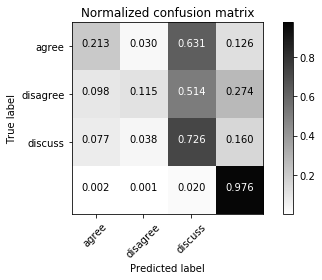

In [60]:
sc.report_score(actual, predicted)
print("F1 Score")
print(f1_score(actual, predicted, average = None))
print("Avg Precision Score")
print(precision_score(actual, predicted, average = None))
matrix = confusion_matrix(actual,predicted)
plot_confusion_matrix(matrix, classes=["agree","disagree", "discuss"],
                      title='Normalized confusion matrix')
plt.show()